### this dev notebook is to perform cue based and decision based analyses on segments of the tree maze. 

#### imports

In [202]:
import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.text import Text
import seaborn as sns

import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import plot_functions as PF
import TrialAnalyses as TA
from importlib import reload  # Python 3.4+ only.


#### paths

In [2]:
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = Path('/mnt/o/giocomo/alexg/Clustered/')
oakPaths['PreProcessed'] = Path('/mnt/o/giocomo/alexg/PreProcessed/')
oakPaths['Raw'] = Path('/mnt/o/giocomo/alexg/RawData/InVivo/')
oakPaths['Analyses'] = Path('/mnt/o/giocomo/alexg/Analyses')

In [3]:
sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})


####  fucntion to load all data analyses from the session 

In [4]:
def loadSessionData(sessionPaths):
    wfi = {}
    bin_spikes = {}
    fr = {}
    
    mods = {}
    params = TA.getParamSet()
    for k,pp in params.items():
        s =''
        for p in pp:
            s+='-'+p
        mods[k]=s[1:]
        
    for ut in ['Cell','Mua']:
        with sessionPaths[ut+'_WaveFormInfo'].open(mode='rb') as f:
            wfi[ut] = pkl.load(f)
        bin_spikes[ut]=np.load(sessionPaths[ut+'_Bin_Spikes'])
        fr[ut] = np.load(sessionPaths[ut+'_FR'])
    
    with sessionPaths['Spike_IDs'].open() as f:
        ids = json.load(f)
    with sessionPaths['ZoneAnalyses'].open(mode='rb') as f:
        za = pkl.load(f)
    
    PosDat = TMF.getBehTrackData(sessionPaths)
    
    TrialLongMat = pd.read_csv( sessionPaths['TrLongPosMat'],index_col=0)
    TrialFRLongMat = pd.read_csv(sessionPaths['TrLongPosFRDat'],index_col=0)
    fitTable = pd.read_csv(sessionPaths['TrModelFits'],index_col=0)
    TrialConds = pd.read_csv(sessionPaths['TrialCondMat'] ,index_col=0)

    
    if isinstance(fitTable,pd.core.frame.DataFrame):
        nUnits = fitTable.shape[0]
        x=[]
        for i in np.arange(nUnits):
            if np.isnan(fitTable['modelNum'][i]):
                x.append('UnCla')
            else:
                x.append(mods[fitTable['modelNum'][i]])
        fitTable['selMod'] = x
    
    dat = {}
    dat['wfi'] = wfi
    dat['bin_spikes'] = bin_spikes
    dat['fr'] = fr
    
    dat['ids'] = ids
    dat['za'] = za

    dat['PosDat'] = PosDat
    dat['TrialLongMat'] = TrialLongMat
    dat['TrialFRLongMat'] = TrialFRLongMat
    dat['TrialModelFits'] = fitTable
    dat['TrialConds'] = TrialConds
    
    return dat

#### load session data

In [8]:

an = 'Li'
fn = oakPaths['Root'] / (an+'_AnalysesTable.csv')
aTable = pd.read_csv(fn,index_col=0)

fn = oakPaths['Root'] / (an+'_SessionPaths.pkl')
with fn.open(mode="rb") as f:
    sePaths = pkl.load(f)

se = 'Li_T3g_062718'
dat = loadSessionData(sePaths[se])

Loading Beh Tracking Data
Complete.


#### univariate analyses gathering the segments of branches and perfming trial wise stats as a function of descion and cue

In [1837]:
trDat = dat['TrialLongMat']
trConds = dat['TrialConds']
cellDat = trDat.copy()
nCells = len(dat['ids']['cells'])
nMua = len(dat['ids']['muas'])
nUnits = nCells+nMua

# fixed variables (don't change with cell)
locs = TMF.ZonesNames
Trials = trConds[trConds['Good']].index.values
nTrials = len(Trials)

FeatIDs = {'A':[1],'Stem':[0,1,2],'Arm': [3,4]}
Segs =  FeatIDs.keys()
HA = ['Home','SegA']
Stem = ['Home','SegA','Center']
L_Arm = ['SegE', 'I2', 'SegF', 'G3', 'SegG', 'G4']
R_Arm = ['SegB', 'I1', 'SegC', 'G1', 'SegD', 'G2']

# variable to be stored
#uni_LvR_Analyses = {'Stats':{'Cue':{},'Desc':{},'Cue_Desc':{}},'Mean':{'Cue':{},'Desc':{},'Cue_Desc':{}},'SD':{'Cue':{},'Desc':{},'Cue_Desc':{}} } 
uni_LvR_Analyses = {'Cue':{'Stats':{},'Mean':{},'SD':{}},'Desc':{'Stats':{},'Mean':{},'SD':{}},'Cue_Desc':{'Stats':{},'Mean':{},'SD':{}}}

Conds = ['Cue','Desc','Cue_Desc']
dat_meas = ['Stats','Mean','SD']

all_dat_spl = {} # only used for plotting as it has overlapping data points; not necessary to store it.

for unitNum in np.arange(nUnits):
    
    # splits of data per cell
    dat_splits = {}
    for k in ['Cue','Desc']:
        dat_splits[k] = {}
        for kk in FeatIDs.keys():
            dat_splits[k][kk] = {}      
    dat_splits['Cue_Desc'] = {'Co_Arm':{},'L_Arm':{},'R_Arm':{}}

    
    if unitNum==0:
        for k in Conds:
            for ii in dat_meas:
                if ii=='Stats':
                    for jj in ['T','P','S']:
                        uni_LvR_Analyses[k][ii][jj] = pd.DataFrame(np.zeros((nUnits,3)),columns=dat_splits[k].keys())
                else:
                    for jj in ['L','R']:
                        uni_LvR_Analyses[k][ii][jj] = pd.DataFrame(np.zeros((nUnits,3)),columns=dat_splits[k].keys())
                    
    if unitNum<nCells:
        tt = dat['ids']['cells'][str(unitNum)][0]
        cl = dat['ids']['cells'][str(unitNum)][1]
        fr = dat['TrialFRLongMat']['cell_'+str(unitNum)]
        tR2 = dat['TrialModelFits']['testR2'][unitNum]
        selMod = dat['TrialModelFits']['selMod'][unitNum]
    else:
        muaID = unitNum-nCells
        tt = dat['ids']['muas'][str(muaID)][0]
        cl = dat['ids']['muas'][str(muaID)][1]
        fr = dat['TrialFRLongMat']['mua_'+str(muaID)] 
        tR2 = dat['TrialModelFits']['testR2'][unitNum]
        selMod = dat['TrialModelFits']['selMod'][unitNum]

    # get mean fr per trial per partition
    mPartFRDat = pd.DataFrame(np.zeros((nTrials,3)),columns=FeatIDs) 
    cue = trConds.loc[Trials,'Cues'].values
    desc = trConds.loc[Trials,'Desc'].values
    cnt =0
    for tr in Trials:
        subset = (trDat['trID']==tr) & (trDat['IO']=='Out')
        for k,v in FeatIDs.items():
            mPartFRDat.loc[cnt,k]=np.nanmean(fr[subset].values[v])
        cnt+=1 

    # univariate cue and desciscion tests by maze part
    LvR = {}
    l = {}
    r = {}
    
    # First & Second analyses: Cue/Desc
    k = 'Cue'
    l[k] = cue=='L'
    r[k] = cue=='R'

    k = 'Desc'
    l[k]=desc=='L'
    r[k]=desc=='R'
    
    for k in ['Cue','Desc']:
        LvR[k] = pd.DataFrame(np.zeros((3,3)),index=Segs,columns=['T','P','S'])
        for kk in Segs: 
            lfr = mPartFRDat[kk][l[k]]
            rfr = mPartFRDat[kk][r[k]]
            temp = stats.ttest_ind(lfr,rfr)
            LvR[k].loc[kk,'T'] = temp[0]
            LvR[k].loc[kk,'P'] = temp[1]
            dat_splits[k][kk]['l'] = lfr.values
            dat_splits[k][kk]['r'] = rfr.values
        LvR[k]['S'] = getSigLevel(LvR[k]['P'])


    # thir analysis: Correct v Incorrect by L/R arm
    k = 'Cue_Desc'
    LvR[k] = pd.DataFrame(np.zeros((3,3)),index=['Co_Arm','L_Arm','R_Arm'],columns=['T','P','S'])

    l = {}
    r = {}

    kk = 'Co_Arm'
    l[kk] = mPartFRDat['Arm'][(cue=='L')&(desc=='L')]
    r[kk] = mPartFRDat['Arm'][(cue=='R')&(desc=='R')]

    kk = 'L_Arm'
    l[kk]=mPartFRDat['Arm'][(desc=='L')&(cue=='L')]
    r[kk]=mPartFRDat['Arm'][(desc=='L')&(cue=='R')]

    kk = 'R_Arm'
    l[kk]=mPartFRDat['Arm'][(desc=='R')&(cue=='L')]
    r[kk]=mPartFRDat['Arm'][(desc=='R')&(cue=='R')]

    for kk in ['Co_Arm','L_Arm','R_Arm']:
        temp = stats.ttest_ind(l[kk],r[kk])
        LvR[k].loc[kk,'T'] = temp[0]
        LvR[k].loc[kk,'P'] = temp[1]
        dat_splits[k][kk]['l'] = l[kk].values
        dat_splits[k][kk]['r'] = r[kk].values

    LvR[k]['S'] = getSigLevel(LvR[k]['P'])

    # aggreagate results.
    mlr = {}
    slr = {}
    for k,v in dat_splits.items():
        mlr[k] = pd.DataFrame(np.zeros((3,2)),index=v.keys(),columns=['L','R'])
        slr[k] = pd.DataFrame(np.zeros((3,2)),index=v.keys(),columns=['L','R'])
        cnt = 0
        for kk,vv in v.items():
            l = vv['l']
            r = vv['r']
            mlr[k].loc[kk] = [np.mean(l),np.mean(r)]
            slr[k].loc[kk] = [stats.sem(l),stats.sem(r)]
            cnt+=1
    
    
    for k in Conds: # keys : Cue, Desc, Cue_Desc
        for ii  in dat_meas:
            if ii=='Stats':
                for jj in ['T','P','S']:
                    if unitNum == 0:
                        uni_LvR_Analyses[k][ii][jj] = pd.DataFrame(np.zeros((nUnits,3)),columns=LvR[k].index.values)
                    uni_LvR_Analyses[k]['Stats'][jj].loc[unitNum] = LvR[k][jj] 
            else:
                for jj in ['L','R']:
                    if unitNum == 0:
                        uni_LvR_Analyses[k][ii][jj] = pd.DataFrame(np.zeros((nUnits,3)),columns=LvR[k].index.values)
                    uni_LvR_Analyses[k]['Mean'][jj].loc[unitNum] = mlr[k][jj]
                    uni_LvR_Analyses[k]['SD'][jj].loc[unitNum] = slr[k][jj] 
    
    all_dat_spl[unitNum] = dat_splits


# reorg LvR to a pandas data frame with all the units
CueDescFR_Dat = pd.DataFrame()
for k in Conds:
    cnt = 0
    for kk in ['Mean','SD']:
        for kkk in ['L','R']:

            if kk=='Mean':
                valName = 'MzFR_'+ kkk
            elif kk == 'SD':
                valName = 'SzFR_' + kkk

            if cnt==0:
                y = uni_LvR_Analyses[k][kk][kkk].copy()
                y = y.reset_index()
                y = y.melt(value_vars = uni_LvR_Analyses[k][kk][kkk].columns,id_vars='index',var_name='Seg',value_name= valName)
                y['Cond'] = k
            else:
                z = uni_LvR_Analyses[k][kk][kkk].copy()
                z = z.reset_index()
                z = z.melt(value_vars = uni_LvR_Analyses[k][kk][kkk].columns,id_vars='index',value_name= valName)
                y[valName] = z[valName].copy()
            cnt+=1
    
    for jj in ['T','P','S']:
        z = uni_LvR_Analyses[k]['Stats'][jj].copy()
        z = z.reset_index()
        z = z.melt(value_vars = uni_LvR_Analyses[k]['Stats'][jj].columns ,id_vars='index', var_name = 'Seg', value_name = jj)    
        y[jj] = z[jj]
        
    CueDescFR_Dat = pd.concat((CueDescFR_Dat,y))
    
CueDescFR_Dat['Sig'] = CueDescFR_Dat['P']<0.05  
CueDescFR_Dat.rename(columns={'index':'unitNum'},inplace=True)

print('Univariate Analyses by Maze Segment. Left v Right T-tests.')
print('Session = {}, nUnits = {}'.format(se,nUnits))
for k in ['Cue','Desc','Cue_Desc']:
    print(k)
    print(CueDescFR_Dat[CueDescFR_Dat['Cond']==k][['Seg','Sig']].pivot(columns='Seg').sum())
    print()



Univariate Analyses by Maze Segment. Left v Right T-tests.
Session = Li_T3g_062718, nUnits = 29
Cue
     Seg 
Sig  A        0.0
     Arm     12.0
     Stem     4.0
dtype: float64

Desc
     Seg 
Sig  A        1.0
     Arm     15.0
     Stem     2.0
dtype: float64

Cue_Desc
     Seg   
Sig  Co_Arm    14.0
     L_Arm      4.0
     R_Arm      4.0
dtype: float64



In [1842]:
len(all_dat_spl)

29

KeyError: 'Cond'

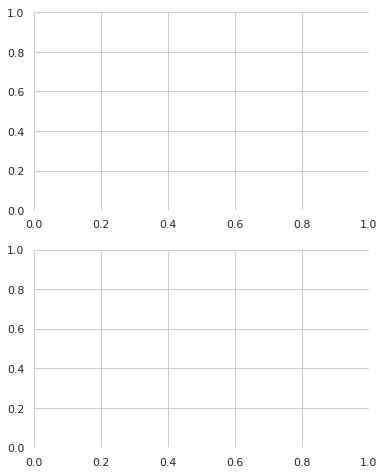

In [1839]:
f,ax = plt.subplots(2,1,figsize=(6,8))
#ax = sns.violinplot(x='Cond',y='T',hue='Seg',data=x,dodge=True,inner = 'quartile',cut=0,scale='count',ax=ax,)
ax_id=0
ax[ax_id] = sns.pointplot(x='Seg',y='T',hue='Cond',data=x[~(x['Cond']=='Cue_Desc')],ax=ax[ax_id],dodge=0.2,estimator=np.median)
l = ax[ax_id].get_legend()
handles, labels = ax[ax_id].get_legend_handles_labels()
l.set_visible(False)
l1=ax[ax_id].legend(handles,labels,bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cond')
#plt.gca().add_artist(l1)
ax[ax_id].set_xlabel('Segment')
ax[ax_id].set_ylabel('T [LvR]')

ax_id =1
ax[ax_id] = sns.pointplot(x='Seg',y='T',hue='Cond',data=x[(x['Cond']=='Cue_Desc')],ax=ax[ax_id],dodge=0.2,estimator=np.median,color=[0.2,0.2,0.9])
l = ax[ax_id].get_legend()
handles, labels = ax[ax_id].get_legend_handles_labels()
l.set_visible(False)
l1=ax[ax_id].legend(handles,labels,bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cond')

#plt.gca().add_artist(l2)
#ax[ax_id].set_title('Cue X Desc')
ax[ax_id].set_xlabel('Decision')
ax[ax_id].set_ylabel('T [LvR]')


#l2=plt.legend(handles[3:],labels[3:],bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Desc')
#ax[0].add_

#### Plots of MFR averages for all session cells

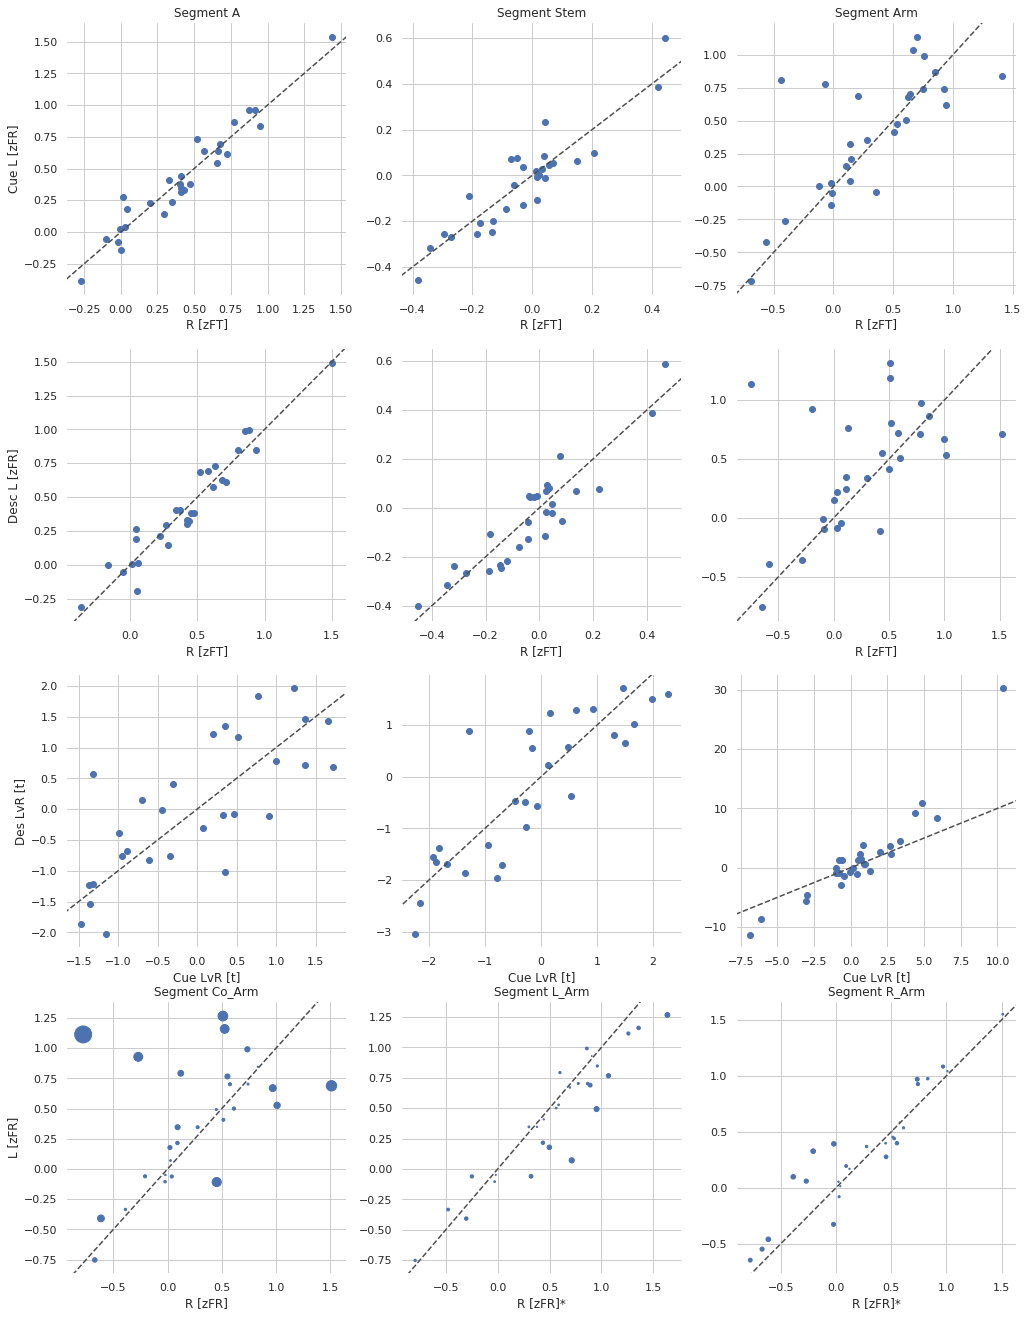

In [1226]:
f,ax = plt.subplots(4,3,figsize=(17,23))

cnt1 = 0
for c in ['Cue','Desc','Ts']:
    cnt2 = 0
    for s in Segs:
        if c == 'Ts':
            subset = (CueDescFR_Dat['Cond']=='Cue') & (CueDescFR_Dat['Seg']==s)
            x = CueDescFR_Dat[subset]['T']
            subset = (CueDescFR_Dat['Cond']=='Desc') & (CueDescFR_Dat['Seg']==s)
            y= CueDescFR_Dat[subset]['T']
        else:
            subset = (CueDescFR_Dat['Cond']==c) & (CueDescFR_Dat['Seg']==s)
            x = CueDescFR_Dat[subset]['MzFR_R']
            y = CueDescFR_Dat[subset]['MzFR_L']
        
        plt.sca(ax[cnt1,cnt2])
        plt.scatter(x=x,y=y)
        #ax[cnt1,cnt2]=sns.scatterplot(x=x,y=y,ax=ax[cnt1,cnt2])
        xlim = ax[cnt1,cnt2].get_xlim()
        ylim =ax[cnt1,cnt2].get_ylim()
        mi = np.min([xlim,ylim])
        ma = np.max([xlim,ylim])
        ax[cnt1,cnt2].plot([mi,ma], [mi, ma], ls="--", c=".3")
        ax[cnt1,cnt2].set_xlim(xlim)
        ax[cnt1,cnt2].set_ylim(ylim)
        
        _,p=stats.ttest_rel(x,y)
        if p<0.05:
            pp = '*'
        else:
            pp = ''
            
        if (cnt1==1) or (cnt1==0):
            ax[cnt1,cnt2].set_xlabel('R [zFT]' +pp)

        if cnt2==0:
            ax[cnt1,cnt2].set_ylabel(c + ' L [zFR]')
        else:
            ax[cnt1,cnt2].set_ylabel('')
        
        if cnt1==2:
            ax[cnt1,cnt2].set_xlabel('Cue LvR [t]' + pp)
            if cnt2==0:
                ax[cnt1,cnt2].set_ylabel('Des LvR [t]')
        
        if cnt1==0:
            ax[0,cnt2].set_title('Segment ' + s)
        
        cnt2+=1
    cnt1+=1
    
c = 'Cue_Desc'
cnt2 = 0
for s in ['Co_Arm','L_Arm','R_Arm']:
    subset = (CueDescFR_Dat['Cond']==c) & (CueDescFR_Dat['Seg']==s)
    x = CueDescFR_Dat[subset]['MzFR_R']
    subset = (CueDescFR_Dat['Cond']==c) & (CueDescFR_Dat['Seg']==s)
    y = CueDescFR_Dat[subset]['MzFR_L']
    z = np.abs(CueDescFR_Dat[subset]['T'])
    
    plt.sca(ax[cnt1,cnt2])
    plt.scatter(x=x,y=y,s=z*10)
    #ax[cnt1,cnt2]=sns.scatterplot(x=x,y=y,ax=ax[cnt1,cnt2])
    xlim = ax[cnt1,cnt2].get_xlim()
    ylim =ax[cnt1,cnt2].get_ylim()
    mi = np.min([xlim,ylim])
    ma = np.max([xlim,ylim])
    ax[cnt1,cnt2].plot([mi,ma], [mi, ma], ls="--", c=".3")
    ax[cnt1,cnt2].set_xlim(xlim)
    ax[cnt1,cnt2].set_ylim(ylim)
    
    _,p=stats.ttest_rel(x,y)
    if p<0.05:
        pp = '*'
    else:
        pp = ''
    
    ax[cnt1,cnt2].set_xlabel('R [zFR]' +pp)
    if cnt2==0:
        ax[cnt1,cnt2].set_ylabel('L [zFR]')

    ax[cnt1,cnt2].set_title('Segment ' + s)

    cnt2+=1


In [218]:
def getSigLevel(pvals):
    s = np.array(['']*len(pvals))
    cnt = 0
    for p in pvals:
        if p<0.001:
            s[cnt] = '***'
        elif p<0.01:
            s[cnt] = '**'
        elif p<0.05:
            s[cnt] = '*'
        else:
            s[cnt] = ''
        cnt+=1
    return s

#### univariate results plots

In [1152]:
def datBarPlots(m,s,ax,xlabels,colors):
    nSubTypes,nGroups = m.shape
    w = 0.4
    alpha = 0.5
    x1 = np.arange(nSubTypes)-w/2
    ax.bar(x1,m[:,0],w,label='L',color=colors[0],alpha=alpha)
    x2 = np.arange(nSubTypes)+w/2
    ax.bar(x2,m[:,1],w,label='R',color=colors[1],alpha=alpha)
    
    for ss in np.arange(nSubTypes):
        ax.plot([x1[ss],x1[ss]], [-s[ss,0],s[ss,0]]+m[ss,0],'kd-',lw=3,markersize=3)
        ax.plot([x2[ss],x2[ss]], [-s[ss,1],s[ss,1]]+m[ss,1],'kd-',lw=3,markersize=3)
        
    ax.set_xticks(np.arange(nSubTypes))
    ax.set_xticklabels(xlabels)
    return ax

def datScatPlot(dat,ax,colors):
    w = 0.4
    alpha=0.5
    mSize = 3
    nSubTypes=len(dat.keys())
    x1 = np.arange(nSubTypes)-w/2
    x2 = np.arange(nSubTypes)+w/2
    
    cnt=0
    for k,v in dat.items():
        nDat = len(v['l'])
        xx1 = x1[cnt]+(np.random.rand(nDat)-0.5)*w/2
        nDat = len(v['r'])
        xx2 = x2[cnt]+(np.random.rand(nDat)-0.5)*w/2
        ax.scatter(xx1,v['l'],marker='o',color=colors[0],alpha=alpha,s=mSize)
        ax.scatter(xx2,v['r'],marker='o',color=colors[1],alpha=alpha,s=mSize)
        cnt+=1
    return ax

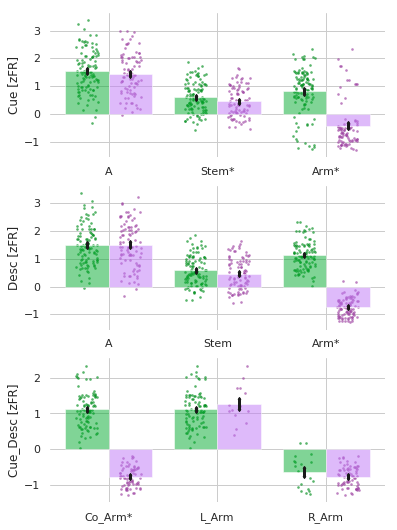

In [1263]:

unitNum = 24

f,ax=plt.subplots(3,1,figsize=(6,9))

#bars
pal = sns.xkcd_palette(['kelly green','light purple'])
cnt = 0
for a in ['Cue','Desc','Cue_Desc']:
    subset = (CueDescFR_Dat['Cond']==a) & (CueDescFR_Dat['unitNum']==unitNum)
    xlabs = CueDescFR_Dat[subset]['Seg'].values + CueDescFR_Dat[subset]['S'].T.values
    ax[cnt] = datBarPlots(CueDescFR_Dat[subset][['MzFR_L','MzFR_R']].values , CueDescFR_Dat[subset][['SzFR_L','SzFR_R']].values ,ax[cnt],xlabs,pal)
#     xlabs = uni_LvR_Analyses[a]['Stats']['T'].columns.values + uni_LvR_Analyses[a]['Stats']['S'].loc[unitNum].values
#     ax[cnt] = datBarPlots(uni_LvR_Analyses[a]['Mean'][unitNum],uni_LvR_Analyses[a]['SD'][unitNum],ax[cnt],xlabs,pal)
    cnt+=1
    
#scatter
pal = np.array(sns.xkcd_palette(['emerald green','medium purple']))
cnt = 0
for a in ['Cue','Desc','Cue_Desc']:
    ax[cnt] =datScatPlot(all_dat_spl[unitNum][a],ax[cnt],pal)
    ax[cnt].set_ylabel(a + ' [zFR]')
    cnt+=1
   


## Decoding analyses

In [1716]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score as bac
from joblib import Parallel, delayed

def getPerm_Pval(nullDist,score):
    nP = len(nullDist)
    p = 1-np.sum(score>nullDist)/nP
    if p==0:
        p = 1/(nP+1)
    if p==1:
        p = 1-1/(nP+1)
    return p

def getPerm_Z(nullDist,score):
    m = np.mean(nullDist)
    s = np.std(nullDist)
    
    return (score-m)/s

def correctTrials_Decoder(train,test):
    res = pd.DataFrame(np.zeros((3,4)),columns=['Test','BAc','P','Z']) 
    
    temp = mod.fit(X_train[train],y_train[train])
    
    res.loc[0,'Test'] = 'Model'
    y_hat = temp.predict(X_train[test])
    res.loc[0,'BAc'] = bac(y_train[test],y_hat)*100

    # shuffle for held out train set
    mod_sh = np.zeros(nSh)
    for sh in np.arange(nSh):
        y_perm_hat = np.random.permutation(y_hat)
        mod_sh[sh] = bac(y_train[test],y_perm_hat)*100
    res.loc[0,'Z'] = getPerm_Z(mod_sh, res.loc[0,'BAc'] )
    res.loc[0,'P'] = getPerm_Pval(mod_sh, res.loc[0,'BAc'] )

    # predictions on x test
    y_hat = temp.predict(X_test)
    res.loc[1,'Test'] = 'Cue'
    res.loc[1,'BAc'] = bac(y_test_cue,y_hat)*100

    res.loc[2,'Test'] = 'Desc'
    res.loc[2,'BAc'] = bac(y_test_desc,y_hat)*100

    # shuffles for ytest cue/desc
    cue_sh = np.zeros(nSh)
    desc_sh = np.zeros(nSh)
    for sh in np.arange(nSh):
        y_perm_hat = np.random.permutation(y_hat)
        cue_sh[sh] = bac(y_test_cue,y_perm_hat)*100
        desc_sh[sh] = bac(y_test_desc,y_perm_hat)*100

    res.loc[1,'Z'] = getPerm_Z(cue_sh, res.loc[1,'BAc'] )
    res.loc[1,'P'] = getPerm_Pval(cue_sh, res.loc[1,'BAc'] )

    res.loc[2,'Z'] = getPerm_Z(desc_sh, res.loc[2,'BAc'] )
    res.loc[2,'P'] = getPerm_Pval(desc_sh, res.loc[2,'BAc'] )

    return res

def balancedCoIncoTrial_Decoder(pe,feats):
    
    res = pd.DataFrame(np.zeros((2,4)),columns=['Test','BAc','P','Z'])

    # sample correct trials to match the number of incorrect trials.
    samp_co_trials = np.random.choice(TrSets['co'],nInCo,replace=False)
    
    train = np.concatenate( (TrSets['inco'], samp_co_trials ))
    test = np.setdiff1d(TrSets['co'], samp_co_trials)

    X_train = allZoneFR.loc[train,feats].values
    X_test = allZoneFR.loc[test,feats].values

    Y_cue_train = predVec['Cue'][train]
    Y_desc_train = predVec['Desc'][train]

    Y_test = predVec['Cue'][test] # cue and desc trials are the on the test set.      

    # model trained on the cue
    res.loc[0,'Test'] = 'Cue'
    cue_mod = mod.fit(X_train,Y_cue_train)
    y_cue_hat = cue_mod.predict(X_test)
    res.loc[0,'BAc']  = bac(Y_test,y_cue_hat)*100

    cue_sh = np.zeros(nSh)
    for sh in np.arange(nSh):
        y_perm = np.random.permutation(Y_test)
        cue_sh[sh] = bac(y_perm,y_cue_hat)*100

    res.loc[0,'Z'] = getPerm_Z(cue_sh, res.loc[0,'BAc'] )
    res.loc[0,'P'] = getPerm_Pval(cue_sh, res.loc[0,'BAc'] )

    # model trained on the desc
    res.loc[1,'Test'] = 'Desc'
    desc_mod = mod.fit(X_train,Y_desc_train)
    y_desc_hat = desc_mod.predict(X_test)
    res.loc[1,'BAc']  = bac(Y_test,y_desc_hat)*100

    desc_sh = np.zeros(nSh)
    for sh in np.arange(nSh):
        y_perm = np.random.permutation(Y_test)
        desc_sh[sh] = bac(y_perm,y_desc_hat)*100
    res.loc[1,'Z'] = getPerm_Z(cue_sh, res.loc[1,'BAc'] )
    res.loc[1,'P'] = getPerm_Pval(cue_sh, res.loc[1,'BAc'] )

    return res

def IncoTrial_Decoder(train,test):
    
    res = pd.DataFrame(np.zeros((3,4)),columns=['Test','BAc','P','Z'])
    temp = mod.fit(X_train[train],y_train[train])
    
    res.loc[0,'Test'] = 'Model'
    y_hat = temp.predict(X_train[test])
    res.loc[0,'BAc'] = bac(y_train[test],y_hat)*100

    # shuffle for held out train set
    mod_sh = np.zeros(nSh)
    for sh in np.arange(nSh):
        y_perm_hat = np.random.permutation(y_hat)
        mod_sh[sh] = bac(y_train[test],y_perm_hat)*100
    res.loc[0,'Z'] = getPerm_Z(mod_sh, res.loc[0,'BAc'] )
    res.loc[0,'P'] = getPerm_Pval(mod_sh, res.loc[0,'BAc'] )

    # predictions on x test
    y_hat = temp.predict(X_test)
    res.loc[1,'Test'] = 'Cue'
    res.loc[1,'BAc'] = bac(y_test_cue,y_hat)*100

    res.loc[2,'Test'] = 'Desc'
    res.loc[2,'BAc'] = 100-res.loc[1,'BAc'] 

    # shuffles for ytest cue/desc
    cue_sh = np.zeros(nSh)
    for sh in np.arange(nSh):
        y_perm_hat = np.random.permutation(y_hat)
        cue_sh[sh] = bac(y_test_cue,y_perm_hat)*100

    res.loc[1,'Z'] = getPerm_Z(cue_sh, res.loc[1,'BAc'] )
    res.loc[1,'P'] = getPerm_Pval(cue_sh, res.loc[1,'BAc'] )

    res.loc[2,'Z'] = getPerm_Z(100-cue_sh, res.loc[2,'BAc'] )
    res.loc[2,'P'] = getPerm_Pval(100-cue_sh, res.loc[2,'BAc'] )

    return res


### Decoding Analyses Data Structure :
Putting the FR for the first 7 positions of each trial trajectory for every unit in the session. The Wide matrix is #trials x (7 * #units ) - 'allZoneFR'. The variable unitIDs has the index of each cell in the allZoneFR matrix.

In [1855]:
gTrialsIDs = trConds['Good']
Trials = trConds[gTrialsIDs].index.values
nTrials = len(Trials)
CoTrials =  trConds[gTrialsIDs & (trConds['Co']=='Co')].index.values
InCoTrials = trConds[gTrialsIDs & (trConds['Co']=='InCo')].index.values

TrSets = {}
TrSets['all'] = np.arange(nTrials)
_,idx,_=np.intersect1d(np.array(Trials),np.array(CoTrials),return_indices=True)
TrSets['co'] = idx
_,idx,_=np.intersect1d(np.array(Trials),np.array(InCoTrials),return_indices=True)
TrSets['inco'] = idx

cueVec = trConds.loc[gTrialsIDs]['Cues'].values
descVec = trConds.loc[gTrialsIDs]['Desc'].values
coVec = trConds.loc[gTrialsIDs]['Co'].values
predVec = {'Cue':cueVec, 'Desc':descVec, 'Co': coVec}

allZoneFR = np.zeros((nTrials,7*nUnits))
unitIDs = np.zeros((nUnits,7),dtype=int)

for t in np.arange(nTrials):
    subset = (trDat['trID']==Trials[t]) & (trDat['IO']=='Out')
    cnt =0 
    for c in np.arange(nCells):
        cc = c*7
        unitIDs[cnt] = np.arange(cc,cc+7,dtype=int)
        allZoneFR[t,(cc):(cc+7)] = dat['TrialFRLongMat']['cell_'+str(c)][subset].values[:7]
        cnt+=1
    for m in np.arange(nMua):
        mm = m*7+(cc+7)
        
        unitIDs[cnt] = np.arange(mm,mm+7,dtype=int)
        allZoneFR[t,(mm):(mm+7)] = dat['TrialFRLongMat']['mua_'+str(m)][subset].values[:7]
        cnt+=1
allZoneFR = pd.DataFrame(allZoneFR)


array(['Co', 'InCo', 'Co', 'InCo', 'Co', 'InCo', 'InCo', 'InCo', 'Co',
       'Co', 'InCo', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co',
       'InCo', 'Co', 'InCo', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co',
       'Co', 'InCo', 'InCo', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co',
       'Co', 'InCo', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'InCo',
       'InCo', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co',
       'Co', 'Co', 'Co', 'InCo', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co',
       'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co',
       'Co', 'Co', 'Co', 'Co', 'InCo', 'InCo', 'Co', 'Co', 'Co', 'Co',
       'InCo', 'InCo', 'InCo', 'Co', 'Co', 'InCo', 'Co', 'Co', 'Co', 'Co',
       'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'InCo', 'Co', 'Co', 'Co', 'Co',
       'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'InCo', 'Co',
       'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'Co', 'InCo', 'Co', 'Co',
       'Co', 'Co', 'Co', 'Co', 'InCo', 'Co', 'Co', 'C

## I. Model trained on correct trials, tested on held out correct trials, and incorrect trials 
Decoding Analyses Code: Train on correct trials on XVal sets, each fold mold further tested on Incorrect Trials.
Logistic Regression model.

In [1705]:
nFeatures = {'h':np.arange(1),'a':np.arange(2),'center':np.arange(3),'be':np.arange(4),'int':np.arange(5),'cdfg':np.arange(6),'goal':np.arange(7)}
unitNum = 10

nFolds = 10
nRepeats = 10
nSh = 50
njobs = 20

y_train = predVec['Cue'][TrSets['co']]
y_test_cue = predVec['Cue'][TrSets['inco']]
y_test_desc = predVec['Desc'][TrSets['inco']]
rskf = RepeatedStratifiedKFold(n_splits=nFolds,n_repeats=nRepeats, random_state=0)
mod = lm.LogisticRegression(class_weight='balanced',C=1/np.sqrt(len(nF)))

coModsDec = pd.DataFrame()
with Parallel(n_jobs=njobs) as parallel:
    for unitNum in np.arange(nUnits):
        print('Decoding for unit# {}'.format(unitNum))
        for p,nF in nFeatures.items():
            
            feats = unitIDs[unitNum][nF]
            X_train = allZoneFR.loc[TrSets['co'], feats ].values
            X_test = allZoneFR.loc[TrSets['inco'], feats ].values

            cnt=0
            t0=time.time()
            r = parallel(delayed(correctTrials_Decoder)(train,test) for train,test in rskf.split(X_train,y_train))
            t1=time.time()
            print('Decoding Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

            res = pd.DataFrame()
            for jj in r:
                res = pd.concat((jj,res))
            res['Loc'] = p
            res['-log(P)'] = -np.log(res['P'])
            res['unit'] = unitNum
            
            coModsDec = pd.concat((coModsDec,res))
coModsDec['se'] = se


Decoding for unit# 0
Decoding Model for h Completed. Time  = 7.80s
Decoding Model for a Completed. Time  = 0.55s
Decoding Model for center Completed. Time  = 0.71s
Decoding Model for be Completed. Time  = 0.75s
Decoding Model for int Completed. Time  = 0.72s
Decoding Model for cdfg Completed. Time  = 0.72s
Decoding Model for goal Completed. Time  = 0.76s
Decoding for unit# 1
Decoding Model for h Completed. Time  = 0.72s
Decoding Model for a Completed. Time  = 0.73s
Decoding Model for center Completed. Time  = 0.73s
Decoding Model for be Completed. Time  = 0.72s
Decoding Model for int Completed. Time  = 0.72s
Decoding Model for cdfg Completed. Time  = 0.74s
Decoding Model for goal Completed. Time  = 0.71s
Decoding for unit# 2
Decoding Model for h Completed. Time  = 0.74s
Decoding Model for a Completed. Time  = 0.74s
Decoding Model for center Completed. Time  = 0.73s
Decoding Model for be Completed. Time  = 0.74s
Decoding Model for int Completed. Time  = 0.76s
Decoding Model for cdfg Com

## II. Models trained on balanced correct/incorrect trials prediciting Cue or Desc. Tested on held out correct trials
equal split between correct and incorrect trials in the training set, separetely predicting for for cue and desc. Then test cue-train model on held out desc test data of correct trials (and vice versa)

In [1729]:
mod = lm.LogisticRegression(class_weight='balanced',C=1/np.sqrt(len(nF)))
nPe = 100
nSh = 50

baModsDec = pd.DataFrame()
with Parallel(n_jobs=njobs) as parallel:
    for unitNum in np.arange(nUnits):
        print('Decoding for unit# {}'.format(unitNum))
        for p,nF in nFeatures.items():

            feats = unitIDs[unitNum][nF]
            t0=time.time()
            r = parallel(delayed(balancedCoIncoTrial_Decoder)(pe, feats) for pe in np.arange(nPe))
            t1=time.time()
            print('Decoding Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

            res = pd.DataFrame()
            for jj in r:
                res = pd.concat((jj,res))
            res['Loc'] = p
            res['-log(P)'] = -np.log(res['P'])
            res['unit'] = unitNum

            baModsDec = pd.concat((baModsDec,res))
    baModsDec['se'] =se

Decoding for unit# 0
Decoding Model for h Completed. Time  = 7.88s
Decoding Model for a Completed. Time  = 0.64s
Decoding Model for center Completed. Time  = 0.76s
Decoding Model for be Completed. Time  = 0.82s
Decoding Model for int Completed. Time  = 0.82s
Decoding Model for cdfg Completed. Time  = 0.79s
Decoding Model for goal Completed. Time  = 0.77s
Decoding for unit# 1
Decoding Model for h Completed. Time  = 0.81s
Decoding Model for a Completed. Time  = 0.83s
Decoding Model for center Completed. Time  = 0.83s
Decoding Model for be Completed. Time  = 0.81s
Decoding Model for int Completed. Time  = 0.82s
Decoding Model for cdfg Completed. Time  = 0.80s
Decoding Model for goal Completed. Time  = 0.78s
Decoding for unit# 2
Decoding Model for h Completed. Time  = 0.82s
Decoding Model for a Completed. Time  = 0.79s
Decoding Model for center Completed. Time  = 0.78s
Decoding Model for be Completed. Time  = 0.80s
Decoding Model for int Completed. Time  = 0.80s
Decoding Model for cdfg Com

## III. Models trained on incorrect trials predicting the Cue. Tested on correct trials and held out incorrect trials. 
train only on incorrect trials, with cue or desc labels.

In [1696]:
nFeatures = {'h':np.arange(1),'a':np.arange(2),'center':np.arange(3),'be':np.arange(4),'int':np.arange(5),'cdfg':np.arange(6),'goal':np.arange(7)}
unitNum = 10

nFolds = 5
nRepeats = 10
nSh = 50
njobs = 20

y_train = predVec['Cue'][TrSets['inco']]
y_test_cue = predVec['Cue'][TrSets['co']]
y_test_desc = predVec['Desc'][TrSets['co']]
rskf = RepeatedStratifiedKFold(n_splits=nFolds,n_repeats=nRepeats, random_state=0)
mod = lm.LogisticRegression(class_weight='balanced',C=np.sqrt(1/len(nF)))

InCoModsDec = pd.DataFrame()
with Parallel(n_jobs=njobs) as parallel:
    for unitNum in np.arange(nUnits):
        print('Decoding for unit# {}'.format(unitNum))
        for p,nF in nFeatures.items():
            feats = unitIDs[unitNum][nF]
            X_train = allZoneFR.loc[TrSets['inco'], feats ].values
            X_test = allZoneFR.loc[TrSets['co'], feats ].values

            cnt=0
            t0=time.time()
            r = parallel(delayed(IncoTrial_Decoder)(train,test) for train,test in rskf.split(X_train,y_train))
            t1=time.time()
            print('Decoding Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

            res = pd.DataFrame()
            for jj in r:
                res = pd.concat((jj,res))
            res['Loc'] = p
            res['-log(P)'] = -np.log(res['P'])
            res['unit'] = unitNum
            
            InCoModsDec = pd.concat((InCoModsDec,res))
InCoModsDec['se'] = se

Decoding for unit# 0
Decoding Model for h Completed. Time  = 15.80s
Decoding Model for a Completed. Time  = 0.30s
Decoding Model for center Completed. Time  = 0.43s
Decoding Model for be Completed. Time  = 0.46s
Decoding Model for int Completed. Time  = 0.46s
Decoding Model for cdfg Completed. Time  = 0.47s
Decoding Model for goal Completed. Time  = 0.45s
Decoding for unit# 1
Decoding Model for h Completed. Time  = 0.46s
Decoding Model for a Completed. Time  = 0.49s
Decoding Model for center Completed. Time  = 0.46s
Decoding Model for be Completed. Time  = 0.44s
Decoding Model for int Completed. Time  = 0.46s
Decoding Model for cdfg Completed. Time  = 0.48s
Decoding Model for goal Completed. Time  = 0.47s
Decoding for unit# 2
Decoding Model for h Completed. Time  = 0.46s
Decoding Model for a Completed. Time  = 0.46s
Decoding Model for center Completed. Time  = 0.47s
Decoding Model for be Completed. Time  = 0.45s
Decoding Model for int Completed. Time  = 0.46s
Decoding Model for cdfg Co

### IV. Predict correct / incorrect.

In [1908]:

def balanceDecoder2(train,test):
        res = pd.DataFrame(np.zeros((1,4)),columns=['Test','BAc','P','Z'])

        temp = mod.fit(X_train[train],y_train[train])

        res.loc[0,'Test'] = 'Model'
        y_hat = temp.predict(X_train[test])
        res.loc[0,'BAc'] = bac(y_train[test],y_hat)*100

        # shuffle for held out train set
        mod_sh = np.zeros(nSh)
        for sh in np.arange(nSh):
            y_perm_hat = np.random.permutation(y_hat)
            mod_sh[sh] = bac(y_train[test],y_perm_hat)*100
        res.loc[0,'Z'] = getPerm_Z(mod_sh, res.loc[0,'BAc'] )
        res.loc[0,'P'] = getPerm_Pval(mod_sh, res.loc[0,'BAc'] )

        return res


y_train = predVec['Co']
nFolds = 10
nRepeats = 10
rskf = RepeatedStratifiedKFold(n_splits=nFolds,n_repeats=nRepeats, random_state=0)

#ba2 = pd.DataFrame()
popBa = pd.DataFrame()
njobs=10
with Parallel(n_jobs=njobs) as parallel:
    for p,nF in nFeatures.items():
        if False:
            mod = lm.LogisticRegression(class_weight='balanced',C=np.sqrt(1/len(nF)))
            for unitNum in np.arange(nUnits):
                print('Decoding for unit# {}'.format(unitNum))
                feats = unitIDs[unitNum][nF]
                X_train = allZoneFR.loc[:,feats].values

                cnt=0
                t0=time.time()
                r = parallel(delayed(balanceDecoder2)(train,test) for train,test in rskf.split(X_train,y_train))
                t1=time.time()
                print('Decoding Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

                res = pd.DataFrame()
                for jj in r:
                    res = pd.concat((jj,res))
                res['Loc'] = p
                res['-log(P)'] = -np.log(res['P'])
                res['unit'] = unitNum

                ba2 = pd.concat((ba2,res))
        
        feats=np.array([])
        for f in nF:
            feats=np.concatenate((feats,np.arange(f,nUnits*7,7)))
        feats=feats.astype(int)
        mod = lm.LogisticRegression(class_weight='balanced',C=np.sqrt(1/len(feats)))
        #mod = lm.LogisticRegression(C=np.sqrt(1/len(feats)))
        X_train = allZoneFR.loc[:,feats].values
        
        cnt=0
        t0=time.time()
        r = parallel(delayed(balanceDecoder2)(train,test) for train,test in rskf.split(X_train,y_train))
        t1=time.time()
        print('Decoding Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

        res = pd.DataFrame()
        for jj in r:
            res = pd.concat((jj,res))
        res['Loc'] = p
        res['-log(P)'] = -np.log(res['P'])
        res['unit'] = unitNum

        popBa = pd.concat((popBa,res))
                    
ba2['se'] = se
popBa['se'] = se

Decoding Model for h Completed. Time  = 0.33s
Decoding Model for a Completed. Time  = 1.20s
Decoding Model for center Completed. Time  = 1.23s
Decoding Model for be Completed. Time  = 1.27s
Decoding Model for int Completed. Time  = 1.28s
Decoding Model for cdfg Completed. Time  = 1.33s
Decoding Model for goal Completed. Time  = 1.35s


In [1900]:
temp = mod.fit(X_train[train],y_train[train])
y_hat = temp.predict(X_train[test])
proba = temp.predict_proba(X_train[test])
#bac(y_train[test],y_hat)*100

In [1905]:
proba[y_hat==y_train[test]],proba[~(y_hat==y_train[test])]

(array([[0.27, 0.73],
        [0.76, 0.24],
        [0.5 , 0.5 ],
        [0.83, 0.17],
        [0.44, 0.56],
        [0.88, 0.12],
        [0.86, 0.14],
        [0.88, 0.12],
        [0.72, 0.28],
        [0.89, 0.11],
        [0.68, 0.32],
        [0.72, 0.28]]), array([[0.56, 0.44],
        [0.15, 0.85],
        [0.67, 0.33],
        [0.5 , 0.5 ]]))

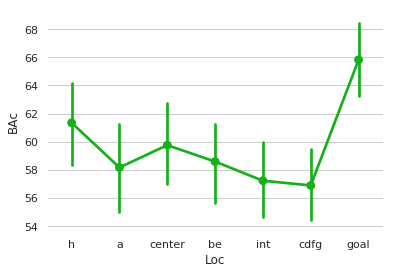

In [1909]:
#sns.pointplot(x='Loc',y='BAc',dodge = 0.3,sort=False,ci='sd',color = pal[0], data= popBa)
sns.pointplot(x='Loc',y='BAc',dodge = 0.3,sort=False,ci=95,color = pal[0], data= popBa)

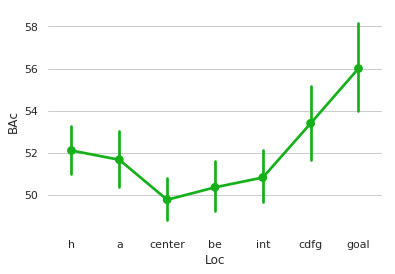

In [1907]:
sns.pointplot(x='Loc',y='BAc',dodge = 0.3,sort=False,ci=95,color = pal[0], data= popBa)

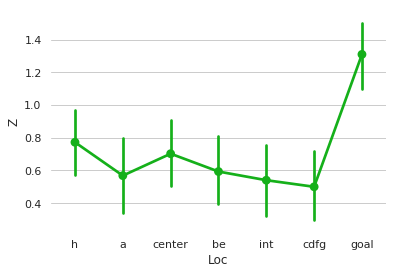

In [1887]:
sns.pointplot(x='Loc',y='Z',dodge = 0.3,sort=False,ci=95,color = pal[0], data= popBa)

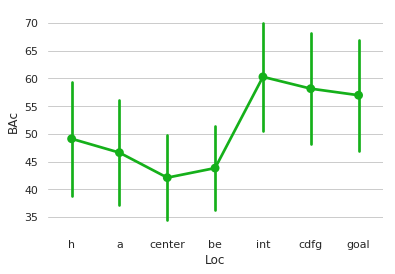

In [1872]:
unitNum = 4
subset = ba2['unit']==unitNum
sns.pointplot(x='Loc',y='BAc',dodge = 0.3,sort=False,ci='sd',color = pal[0], data= ba2[ subset], hue_order = hue_order)

### merge results from the single cell decoding analyses.

In [1741]:
coModsDec['Decoder'] = 'Correct'
baModsDec['Decoder'] = 'Balanced'
InCoModsDec['Decoder'] = 'Incorrect'

singCellDec = pd.concat((coModsDec,baModsDec,InCoModsDec))

singCellDecSummary = singCellDec.groupby(['Loc','Test','unit','Decoder','se']).mean()
singCellDecSummary = singCellDecSummary.reset_index()
singCellDecSummary['Test'] = pd.Categorical(singCellDecSummary['Test'],categories=['Model','Cue','Desc'],ordered=True)
singCellDecSummary.sort_values('Test',inplace=True)
singCellDecSummary['Loc'] = pd.Categorical(singCellDecSummary['Loc'],categories=nFeatures.keys(),ordered=True)
singCellDecSummary.sort_values('Loc',inplace=True)


In [1748]:

def plotMultipleDecoderResults(data):
    f,ax = plt.subplots(2,3,figsize=(18,10))

    cols = ['Correct','Balanced','Incorrect']

    jj=0
    for c in cols:
        subset = (data['Decoder'] == c)

        if c=='Balanced':
            pal =sns.color_palette(desat=.7)[1:3]
            hue_order = ['Cue','Desc']
        else:
            pal =sns.color_palette(desat=.7)[:3]
            hue_order = ['Model','Cue','Desc']

        ii = 0
        ax[ii,jj].set_ylim([-5,110])
        ax[ii,jj].set_yticks([0,25,50,75,100])
        ax[ii,jj].set_xlim([-0.2,6.2])
        ax[ii,jj].axhline(y=50,linestyle='--',color=0.3*np.ones(3),alpha=0.5)
        ax[ii,jj] = sns.pointplot(x='Loc',y='BAc',hue='Test',dodge = 0.3,sort=False,ci='sd',palette = pal, data= data[ subset], ax=ax[ii,jj], hue_order = hue_order)
        ax[ii,jj] = sns.stripplot(x='Loc',y='BAc',hue='Test', dodge = True ,alpha=0.3,palette  = pal, data= data[subset], ax=ax[ii,jj], hue_order = hue_order)

        ax[ii,jj].set_title(c)
        ax[ii,jj].set_xlabel('')
        l=ax[ii,jj].get_legend()
        l.set_visible(False)

        ii=1
        ax[ii,jj] = sns.pointplot(x='Loc',y='Z',hue='Test',dodge = 0.3,sort=False,ci='sd',palette  = pal, data= data[ subset ],ax=ax[ii,jj], hue_order = hue_order)
        ax[ii,jj] = sns.stripplot(x='Loc',y='Z',hue='Test', dodge = True ,alpha=0.3,palette  = pal,data= data[subset],ax=ax[ii,jj], hue_order = hue_order)

        l=ax[ii,jj].get_legend()
        l.set_visible(False)
        if jj==2:
            handles, labels = ax[ii,jj].get_legend_handles_labels()
            if c =='balanced':
                plt.legend(handles[:2],labels[:2],bbox_to_anchor=(1.02, 1), loc=3, borderaxespad=0.,frameon=False,title='Test')
            else:
                plt.legend(handles[:3],labels[:3],bbox_to_anchor=(1.02, 1), loc=3, borderaxespad=0.,frameon=False,title='Test')

        ax[ii,jj].axhline(y=0,linestyle='--',color=0.3*np.ones(3),alpha=0.5)

        if jj==0:
            ax[0,jj].set_ylabel(' BAc ')
            ax[1,jj].set_ylabel(' Z [BAc] ')
        else:
            ax[0,jj].set_ylabel('')
            ax[1,jj].set_ylabel('')

        jj+=1
    return f, ax

plot all decoder results for a single cell.

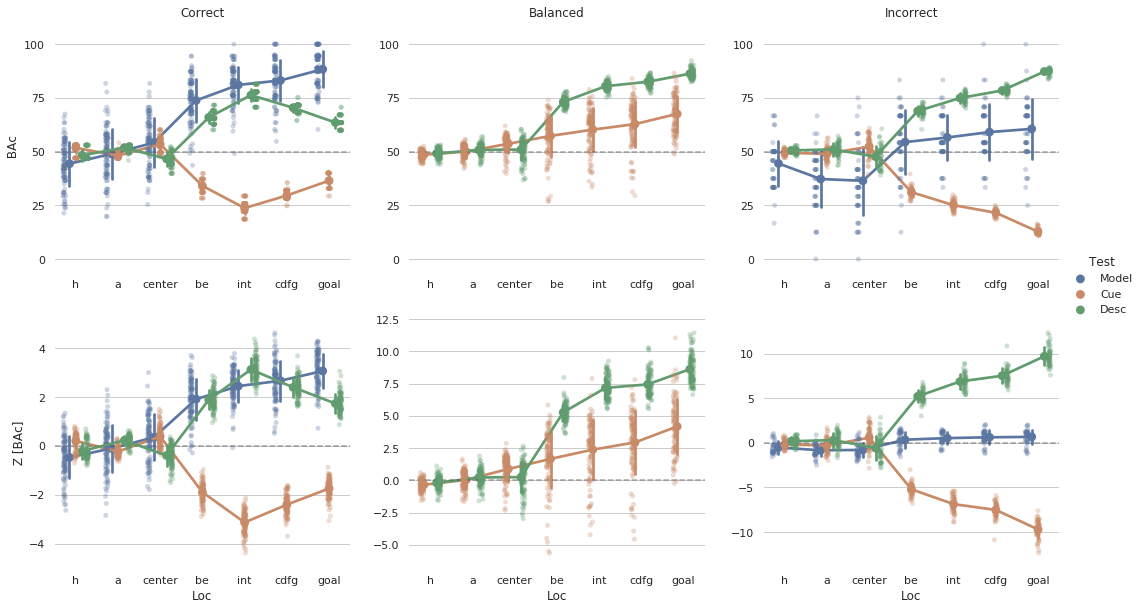

In [1740]:
unitNum = 10
_=plotMultipleDecoderResults(singCellDec[(singCellDec['unit']==unitNum)])

### Plot for all units

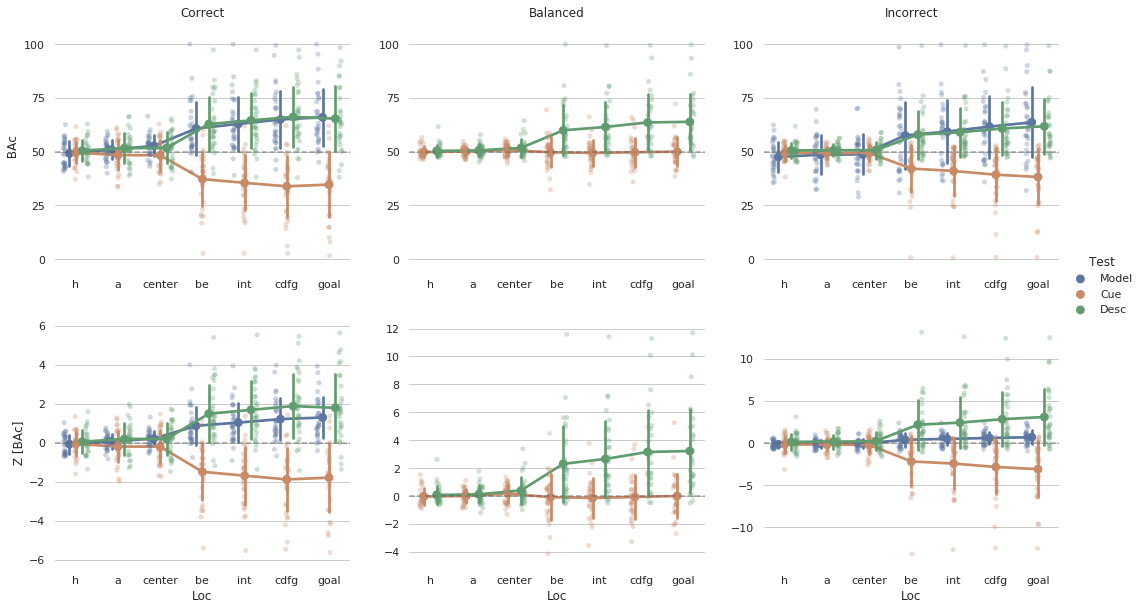

In [1751]:
_=plotMultipleDecoderResults(singCellDecSummary)

## Decoder using all units in a session. Models trained on
1. Correct
2. Balanced 2 Mods (Cue/Desc)
3. InCorrect

In [1747]:
nFeatures = {'h':np.arange(1),'a':np.arange(2),'center':np.arange(3),'be':np.arange(4),'int':np.arange(5),'cdfg':np.arange(6),'goal':np.arange(7)}

with Parallel(n_jobs=njobs) as parallel:
    
    ## First analysis. Correct Model.
    nFolds = 10
    nRepeats = 10
    nPe = 100
    nSh = 50
    njobs = 20
    nInCo = len(InCoTrials)
        
    y_train = predVec['Cue'][TrSets['co']]
    y_test_cue = predVec['Cue'][TrSets['inco']]
    y_test_desc = predVec['Desc'][TrSets['inco']]
    rskf = RepeatedStratifiedKFold(n_splits=nFolds,n_repeats=nRepeats, random_state=0)
    mod = lm.LogisticRegression(class_weight='balanced',C=1/np.sqrt(len(nF)))

    popCoModsDec = pd.DataFrame()
    print('Model Trained on Correct Trials.')
    for p,nF in nFeatures.items():
        feats=np.array([])
        for f in nF:
            feats=np.concatenate((feats,np.arange(f,nUnits*7,7)))
        feats=feats.astype(int)

        X_train = allZoneFR.loc[TrSets['co'], feats ].values
        X_test = allZoneFR.loc[TrSets['inco'], feats ].values

        cnt=0
        t0=time.time()
        r = parallel(delayed(correctTrials_Decoder)(train,test) for train,test in rskf.split(X_train,y_train))
        t1=time.time()
        print('Decoding Pop Correct Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

        res = pd.DataFrame()
        for jj in r:
            res = pd.concat((jj,res))
        res['Loc'] = p
        res['-log(P)'] = -np.log(res['P'])

        popCoModsDec = pd.concat((popCoModsDec,res))  
    popCoModsDec['se'] = se
    popCoModsDec['Decoder'] = 'Correct'
    
    ## Second Analysis. Train cue/desc on correct/incorrect trials (balanced).
    popBaModsDec = pd.DataFrame()
    print('Model Trained on Co/InCo Trials.')
    for p,nF in nFeatures.items():

        feats=np.array([])
        for f in nF:
            feats=np.concatenate((feats,np.arange(f,nUnits*7,7)))
        feats=feats.astype(int)

        t0=time.time()
        r = parallel(delayed(balancedCoIncoTrial_Decoder)(pe, feats) for pe in np.arange(nPe))
        t1=time.time()
        print('Decoding Pop Balanced Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

        res = pd.DataFrame()
        for jj in r:
            res = pd.concat((jj,res))
        res['Loc'] = p
        res['-log(P)'] = -np.log(res['P'])

        popBaModsDec = pd.concat((popBaModsDec,res))
    popBaModsDec['se'] =se
    popBaModsDec['Decoder'] = 'Balanced'
    
    ## Third Analysis. Trained on incorrect trials
    nFolds = 5

    y_train = predVec['Cue'][TrSets['inco']]
    y_test_cue = predVec['Cue'][TrSets['co']]
    y_test_desc = predVec['Desc'][TrSets['co']]
    rskf = RepeatedStratifiedKFold(n_splits=nFolds,n_repeats=nRepeats, random_state=0)
    mod = lm.LogisticRegression(class_weight='balanced',C=np.sqrt(1/len(nF)))

    popInCoModsDec = pd.DataFrame()

    print('Model Trained on InCo Trials.')
    for p,nF in nFeatures.items():
        feats=np.array([])
        for f in nF:
            feats=np.concatenate((feats,np.arange(f,nUnits*7,7)))
        feats=feats.astype(int)

        X_train = allZoneFR.loc[TrSets['inco'], feats ].values
        X_test = allZoneFR.loc[TrSets['co'], feats ].values

        cnt=0
        t0=time.time()
        r = parallel(delayed(IncoTrial_Decoder)(train,test) for train,test in rskf.split(X_train,y_train))
        t1=time.time()
        print('Decoding Pop Incorrect Trials Model for {0} Completed. Time  = {1:.2f}s'.format(p,t1-t0))

        res = pd.DataFrame()
        for jj in r:
            res = pd.concat((jj,res))
        res['Loc'] = p
        res['-log(P)'] = -np.log(res['P'])

        popInCoModsDec = pd.concat((popInCoModsDec,res))
    popInCoModsDec['se'] = se
    popInCoModsDec['Decoder'] = 'Incorrect'
popSingCellDec = pd.concat((popCoModsDec,popBaModsDec,popInCoModsDec))

Model Trained on Correct Trials.
Decoding Pop Correct Model for h Completed. Time  = 8.00s
Decoding Pop Correct Model for a Completed. Time  = 0.58s
Decoding Pop Correct Model for center Completed. Time  = 0.76s
Decoding Pop Correct Model for be Completed. Time  = 0.73s
Decoding Pop Correct Model for int Completed. Time  = 0.75s
Decoding Pop Correct Model for cdfg Completed. Time  = 0.76s
Decoding Pop Correct Model for goal Completed. Time  = 0.74s
Model Trained on Co/InCo Trials.
Decoding Pop Balanced Model for h Completed. Time  = 0.78s
Decoding Pop Balanced Model for a Completed. Time  = 0.77s
Decoding Pop Balanced Model for center Completed. Time  = 0.80s
Decoding Pop Balanced Model for be Completed. Time  = 0.81s
Decoding Pop Balanced Model for int Completed. Time  = 0.81s
Decoding Pop Balanced Model for cdfg Completed. Time  = 0.78s
Decoding Pop Balanced Model for goal Completed. Time  = 0.85s
Model Trained on InCo Trials.
Decoding Pop Incorrect Trials Model for h Completed. Time

#### Merge Results

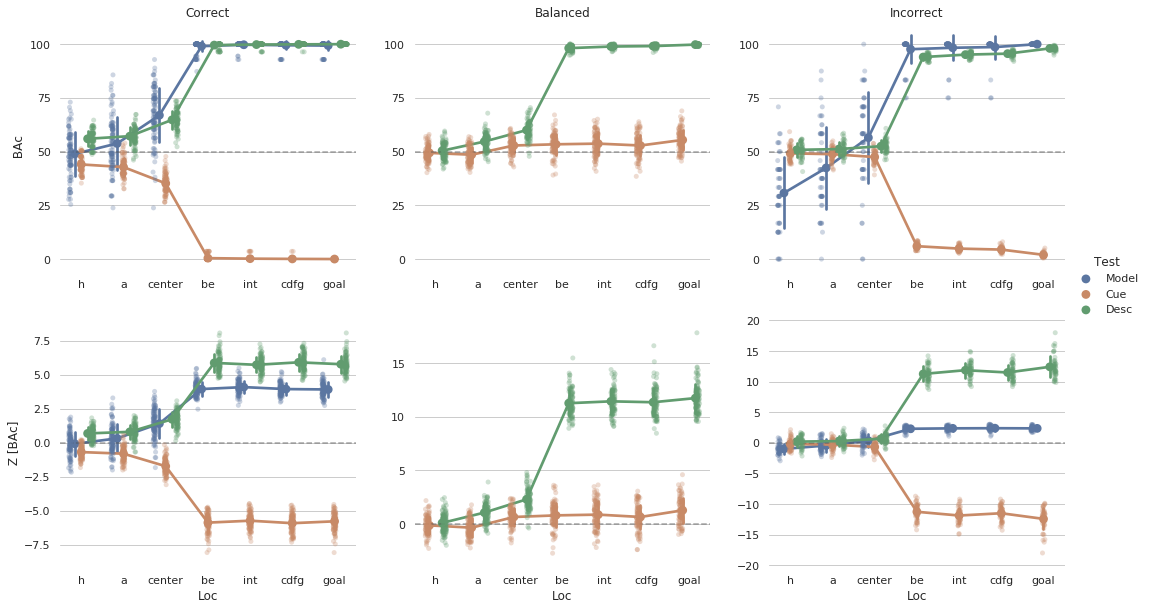

In [1753]:
 _=plotMultipleDecoderResults(popSingCellDec)

In [1761]:
subset = (popSingCellDec['Decoder']=='Balanced') & (popSingCellDec['Loc']=='center')  & (popSingCellDec['Test']=='Cue')  

stats.ttest_1samp(popSingCellDec[subset]['Z'],0)

Ttest_1sampResult(statistic=7.833912306663947, pvalue=5.4355970238858554e-12)

In [1763]:
popSingCellDec[subset]['BAc'].mean()

52.84803951693181

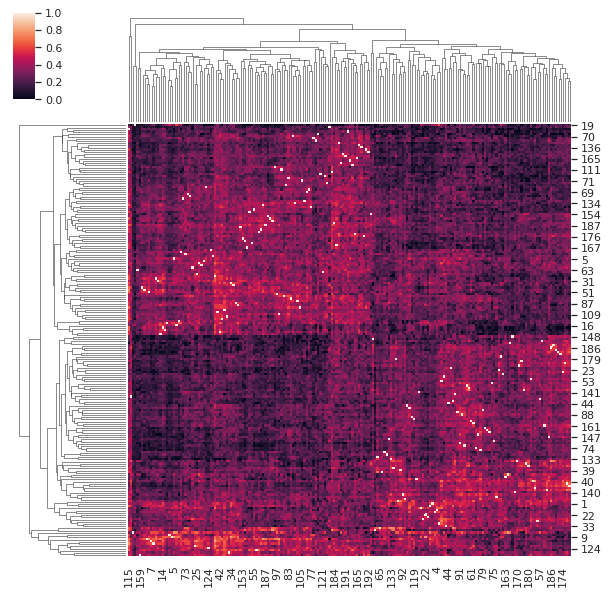

In [1775]:
sns.clustermap(np.matmul(allZoneFR.values,allZoneFR.values.T),standard_scale=1)

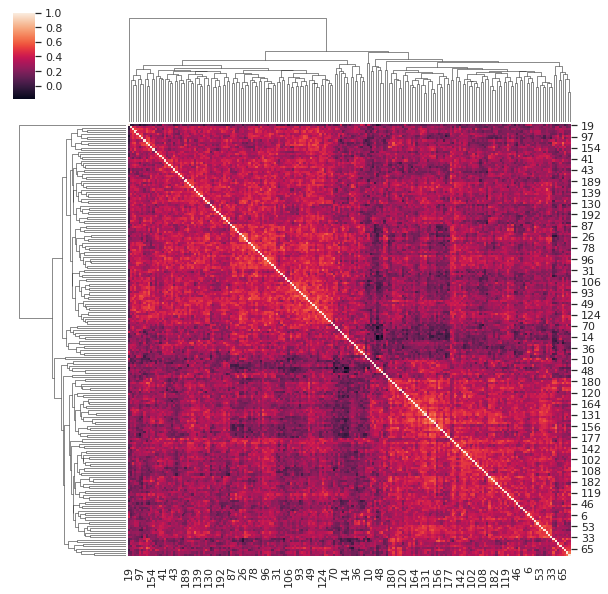

In [1782]:
g = sns.clustermap(np.corrcoef(allZoneFR.values))

In [1785]:
g.dendrogram_col.reordered_ind

[19,
 167,
 135,
 185,
 111,
 97,
 150,
 45,
 166,
 173,
 154,
 181,
 76,
 118,
 27,
 41,
 110,
 146,
 71,
 77,
 43,
 47,
 129,
 117,
 121,
 189,
 125,
 159,
 176,
 183,
 139,
 127,
 191,
 24,
 52,
 130,
 169,
 114,
 136,
 63,
 192,
 153,
 162,
 160,
 172,
 87,
 95,
 34,
 84,
 7,
 26,
 12,
 25,
 83,
 105,
 78,
 137,
 99,
 107,
 103,
 96,
 82,
 90,
 112,
 132,
 31,
 60,
 21,
 42,
 55,
 106,
 13,
 98,
 38,
 51,
 93,
 134,
 2,
 109,
 184,
 49,
 144,
 58,
 187,
 69,
 124,
 73,
 11,
 113,
 123,
 70,
 115,
 89,
 16,
 68,
 14,
 18,
 145,
 165,
 32,
 36,
 64,
 8,
 9,
 0,
 10,
 56,
 157,
 175,
 193,
 48,
 163,
 67,
 128,
 171,
 180,
 152,
 179,
 29,
 39,
 120,
 17,
 149,
 178,
 62,
 164,
 23,
 174,
 147,
 40,
 131,
 161,
 158,
 155,
 188,
 156,
 186,
 190,
 148,
 168,
 177,
 5,
 94,
 143,
 140,
 142,
 88,
 92,
 80,
 101,
 102,
 79,
 74,
 85,
 86,
 108,
 81,
 91,
 59,
 122,
 182,
 61,
 75,
 126,
 100,
 119,
 3,
 1,
 66,
 44,
 46,
 30,
 57,
 141,
 4,
 6,
 15,
 116,
 22,
 50,
 53,
 35,
 37,
 20,
 

In [1786]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
pc = pca.fit_transform(allZoneFR.values)

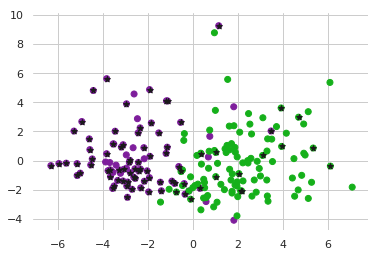

In [1831]:
pal = sns.xkcd_palette(['green','purple'])
desc = np.zeros((194,3))
desc[trConds[trConds['Good']]['Desc'].values=='R']=pal[1]
desc[trConds[trConds['Good']]['Desc'].values=='L']=pal[0]

cues = trConds[trConds['Good']]['Cues'].values

plt.scatter(pc[:,0],pc[:,2],c=desc)
plt.scatter(pc[cues=='R',0],pc[cues=='R',2],marker='*',color='k')



In [1832]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(allZoneFR.values)
kmeans.labels_


array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int32)

In [1836]:

trConds[trConds['Good']][kmeans.labels_==1]['Desc']3

3      R
5      R
6      R
8      R
12     R
18     R
20     R
22     R
23     R
25     R
26     R
31     R
32     R
33     R
36     R
38     R
41     R
43     R
44     R
48     R
50     R
52     R
54     R
57     R
58     R
60     R
61     R
63     R
65     R
66     R
      ..
152    R
154    R
155    R
156    R
161    R
162    R
163    R
165    R
166    R
170    R
171    R
172    R
174    R
177    R
180    R
181    R
185    R
187    R
188    R
191    R
192    R
194    R
195    R
196    R
197    R
199    R
203    R
205    R
207    R
210    R
Name: Desc, Length: 89, dtype: object